# Predicting pneumonia from X-ray image: Checkpoint #1

Members: 
- Claire Boyd
- Jack Gibson
- Benjamin Leiva
- Raul Castellanos

In [217]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


## Load and prepare data

In this section we'll load the csv files we created using the 'collect_image_files()' function of the load module, and create the necessary variables for analyzing the dataset.

In [218]:
# Load csv files
train = pd.read_csv('data/output/train.csv', usecols=['path', 'channel', 'height', 'width', 'label'])
test  = pd.read_csv('data/output/test.csv', usecols=['path', 'channel', 'height', 'width', 'label'])
val   = pd.read_csv('data/output/val.csv', usecols=['path', 'channel', 'height', 'width', 'label'])

# Create 'type' variable
train['type'] = 'train'
test['type'] =  'test'
val['type'] = 'val'

# Create 'size' variable
train['size'] = train['height'] * train['width']
test['size'] = test['height'] * test['width']
val['size'] = val['height'] * val['width']

# Combine datasets
data = pd.concat([train, test, val], ignore_index=True, axis=0)
data = data[['type', 'path', 'channel', 'height', 'width', 'size', 'label']]

# Combined dataset preview
data.head()

,type,path,channel,height,width,size,label
0,train,NORMAL/NORMAL2-IM-0927-0001.jpeg,1,2234,2359,5270006,NORMAL
1,train,NORMAL/NORMAL2-IM-1056-0001.jpeg,1,1067,1422,1517274,NORMAL
2,train,NORMAL/IM-0427-0001.jpeg,1,1357,1828,2480596,NORMAL
3,train,NORMAL/NORMAL2-IM-1260-0001.jpeg,1,1495,1854,2771730,NORMAL
4,train,NORMAL/IM-0656-0001-0001.jpeg,1,1966,2194,4313404,NORMAL


The output from above shows the structure of our data, where each row contains information of an x-ray image. The 'path' column contains the location of the image in the corresponding data type directory (i.e., train, test or val). The 'channel' column describes how many scales of colors our images have. Since all images are x-rays in black and white, all observartions have only 1 channel. The 'height', 'width' and 'size' (height * width) columns contain shape information about the image. Finally, 'label' says if the x-ray is from a healthy person (NORAML) or if its from a person with pneumonia (PNEUMONIA).  

## Descriptive statistics

### 1. Label count:

In [219]:
data.groupby(["type", "label"])["type"].count().reset_index(name="count")

,type,label,count
0,test,NORMAL,468
1,test,PNEUMONIA,780
2,train,NORMAL,2682
3,train,PNEUMONIA,7750
4,val,NORMAL,8
5,val,PNEUMONIA,8


Looking at the table above we see that:
- Training data has 2,682 normal labels (26%) and 7,750 pneumonia ones (74%).
- Testing data has 468 normal x-ray labels (38%) and 780 pneumonia ones (62%).
- Validation data has a 50-50 ratio between normal and pneumonia labels. 

### 2. Height, width and size count

From now on we will focus on creating descriptive statistics for the training data, starting with the height, width and size of our x-ray images in the training data.

In [220]:
# Table with descriptive statistics
pd.set_option('display.float_format', lambda x: '%.0f' % x)
train[["height","width", "size"]].describe(percentiles=[0.1, .25, 0.5, 0.75, 0.9])


,height,width,size
count,10432,10432,10432
mean,968,1321,1403850
std,379,355,939101
min,127,384,48768
10%,568,920,531706
25%,688,1056,727888
50%,888,1284,1140640
75%,1188,1552,1841504
90%,1480,1792,2617809
max,2663,2916,7532028


In [221]:
# Height count by bracket
train['height_bracket'] = 'More than 2000 pixels'
train.loc[(train.loc[:, 'height'] < 2000) & (train.loc[:, 'height'] >= 1500), 'height_bracket'] = 'Between 1500-2000 pixels'
train.loc[(train.loc[:, 'height'] < 1500) & (train.loc[:, 'height'] >= 1000), 'height_bracket'] = 'Between 1000-1500 pixels'
train.loc[(train.loc[:, 'height'] < 1000) & (train.loc[:, 'height'] >= 500), 'height_bracket'] = 'Between 500-1000 pixels'
train.loc[(train.loc[:, 'height'] < 500), 'height_bracket'] = 'Less than 500 pixels'

train.groupby(["type", "height_bracket"])["type"].count().reset_index(name="count").sort_values('count', ascending=False)

,type,height_bracket,count
2,train,Between 500-1000 pixels,5694
0,train,Between 1000-1500 pixels,3302
1,train,Between 1500-2000 pixels,802
3,train,Less than 500 pixels,488
4,train,More than 2000 pixels,147


In [222]:
# Width count by bracket
train['width_bracket'] = 'More than 2000 pixels'
train.loc[(train.loc[:, 'width'] < 2000) & (train.loc[:, 'width'] >= 1500), 'width_bracket'] = 'Between 1500-2000 pixels'
train.loc[(train.loc[:, 'width'] < 1500) & (train.loc[:, 'width'] >= 1000), 'width_bracket'] = 'Between 1000-1500 pixels'
train.loc[(train.loc[:, 'width'] < 1000) & (train.loc[:, 'width'] >= 500), 'width_bracket'] = 'Between 500-1000 pixels'
train.loc[(train.loc[:, 'width'] < 500), 'width_bracket'] = 'Less than 500 pixels'

train.groupby(["type", "width_bracket"])["type"].count().reset_index(name="count").sort_values('count', ascending=False)

,type,width_bracket,count
0,train,Between 1000-1500 pixels,5494
1,train,Between 1500-2000 pixels,2698
2,train,Between 500-1000 pixels,1752
4,train,More than 2000 pixels,383
3,train,Less than 500 pixels,106


## Data pre-processing

In order to decide how to transform and/normalize our data, we first did a brief exploratory analysis on the size of our training data. We created two histograms to help us get a sense of the spread of the height and width of our normal and pneumonia chest x-ray images.

In [223]:
# Height mean
height_mean = train['height'].mean()
height_sd = train['height'].std()
print('Mean of height:', int(height_mean))
print('Starndard deviation of height:', int(height_sd))

Mean of height: 968
Starndard deviation of height: 378


In terms of height, we found that the mean height was 968 and the standard deviation of image height was 378.

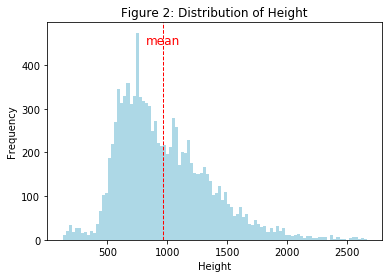

In [224]:
# Distribution of height
height = train.loc[:, 'height']
plt.hist(height, bins=100, color='lightblue')
plt.axvline(height_mean, color='red', linestyle='dashed', linewidth=1)
plt.text(height_mean, plt.ylim()[1]*0.9, 'mean', color='red', fontsize=12, ha='center')
plt.title('Figure 2: Distribution of Height')
plt.xlabel('Height')
plt.ylabel('Frequency')
plt.show()

In [225]:
# Width mean
width_mean = train['width'].mean()
width_sd = train['width'].std()
print('Mean of width:', int(width_mean))
print('Starndard deviation of width:', int(width_sd))

Mean of width: 1320
Starndard deviation of width: 355


Similarly, the mean width was 1320 and the standard deviation of the image width was 355.

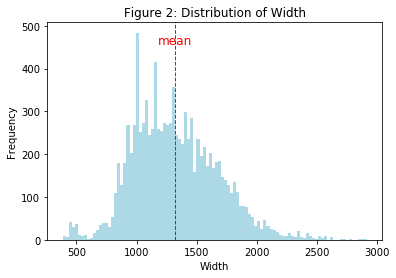

In [226]:
width = train.loc[:, 'width']
plt.hist(width, bins=100, color='lightblue')
plt.axvline(width_mean, color='red', linestyle='dashed', linewidth=1)
plt.text(width_mean, plt.ylim()[1]*0.9, 'mean', color='red', fontsize=12, ha='center')
plt.title('Figure 2: Distribution of Width')
plt.xlabel('Width')
plt.ylabel('Frequency')
plt.show()

Given that we are trying to classify pneumonia images, resolution really does matter for the accuracy of our prediction. Though we are still in the early stages of thinking through how our machine learning model would work, our sense is that the model will largely need to be trained on the amount of lighter gray pixels as opposed to white/black contrast. At this stage, we don’t want to overly simplify our images and lose some of the granularity of what we give our model.

However, we also read here(link: https://medium.com/neuronio/how-to-deal-with-image-resizing-in-deep-learning-e5177fad7d89) that there are efficiency benefits to reducing image size without jeopardizing model accuracy.

Given these conflicting constraints, we thought it made the most sense to transform our image data to the mean pixels in both height and width. But because we didn’t want to lose the image granularity for the images that were larger in pixels than the averages, so we decided to transform our data to the mean height/width in two steps: first we used CenterCrop and then we used Resize.

The reason for choosing to transform the data using CenterCrop first is that we could keep the granularity of the image as well as zoom in on the part of the image will likely give us the most information about the presence of pneumonia (e.g., chest and lungs). This way, we prevent our model from analyzing pixels from, for example, the shoulders or arms regions, and focus on the chest and lungs. Then, we used Resize on the resulting images in order to have homogeneous image sizes in our training data.